In [1]:
from IPython.display import display, Image
from pprint import pprint
from itertools import chain

from ginv import *
sympy.init_printing()

Условие на высшие симметрии (сокращенная запись например $u_{xxx} = u_3$)
\begin{equation}
\begin{aligned}
\mathbf{u_{t}}& + 6 u_1 u + u_3 = 0 \\
\mathbf{u_{\varepsilon }}& - F(t, x, u, u_1, u_2, \ldots, u_5) = 0 \\
\end{aligned}
\end{equation}
Для второго уравнения системы введем полные производные от $F$.
\begin{equation}
\begin{aligned}
\frac{dF}{dt} &= F_t  + F_u (6 u_1 u + u_3) + \sum F_{u_{i}} (6 u_1 u + u_3)_i\\
\frac{dF}{dx} &= F_x  + F_u  u_1 + \sum F_{u_{i}} u_{i+1}
\end{aligned}
\end{equation}

Условие интегрируемости (совместности) данной системы можно записать через $S$-полином (лексикографическое упорядочение $t \succ x $)
\begin{equation}
\big(\mathbf{u_{t}}  + 6 u_1 u + u_3)_\varepsilon 
- \mathbf{u_{\varepsilon t}} + \frac{d}{dt}F = 0
\end{equation}

В последнем уравнении в силу правила дифференцирования Лейбница производная по $\varepsilon $
входит в условие интрегриемости линейно. 
\begin{equation}
6𝑢 𝑢_{\varepsilon 1}+  6𝑢_1 𝑢_{\varepsilon }+ 𝑢_{\varepsilon 3}
\frac{d}{dt}F = 0
\end{equation}
При этом мы можем заменить $u_{\varepsilon }$ на $F$ используя полные производные от $F$.
\begin{equation}
6𝑢 \frac{d}{dx}F+  6𝑢_1 F + \frac{d^3}{dx^3}F + \frac{d}{dt}F = 0
\end{equation}

Поскольку само $F$ не зависит от производных выше пятого порядка можно получить 
систему линейных уравнений на $F$.

In [2]:
eps, t, x = sympy.symbols('ε, t, x', real=True)
U = sympy.Function('u')(eps, t, x)

u, ut, u1, u2, u3, u4, u5 = sympy.symbols('u, ut, u1, u2, u3, u4, u5', real=True)
F = sympy.Function('f')(t, x, u, u1, u2, u3, u4, u5)

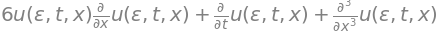

In [3]:
eq1 = U.diff(t) + 6*U*U.diff(x) + U.diff(x, 3)
eq1

In [4]:
func_poly = set([sympy.Add, sympy.Mul, sympy.Pow])
def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a.func in func_poly:
                return a.func(*tuple(cmpct(s) for s in a.args))
            elif a.func != sympy.Derivative:
                return sympy.Symbol(f"{a.func}")
            else:
                m = []
                for xi, k in a.args[1:]:
                    m.append(f"{xi}"*k)
                return sympy.Symbol(f"{a.args[0].func}_{{{''.join(m)}}}", real=True)
    return cmpct(f)

In [5]:
compact(eq1)

In [6]:
compact(eq1.diff(eps))

In [7]:
def Dt(a):
    return a.diff(t) -\
        sum(a.diff(f)*(6*U*U.diff(x) + U.diff(x, 3)).diff(x, k)\
            for k, f in enumerate([u, u1, u2, u3, u4, u5]))
def Dx(a):
    return a.diff(x) +\
        sum(a.diff(f)*U.diff(x, k+1)\
            for k, f in enumerate([u, u1, u2, u3, u4, u5]))

In [8]:
compact(Dx(F))

In [9]:
compact(Dt(F))

In [10]:
toD = {
    t: Dt,\
    x: Dx,\
}
def totalD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(totalD(s) for s in a.args))
        elif (eps, 1) not in a.args:
            return a
        else:
            assert a.args[0] == U
            r = F
            for v, l in a.args[1:]:
                if v != eps:
                    for i in range(l):
                        r = toD[v](r)
            return r

In [11]:
eq2 = totalD(eq1.diff(eps)).expand()
compact(eq2)

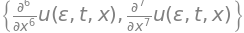

In [12]:
toU = dict((U.diff(x, k), f) for k, f in enumerate([u, u1, u2, u3, u4, u5]))
DF = set()
def lstD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(lstD(s) for s in a.args))
        elif a.args[0] != U:
            return a
        elif a in toU:
            return toU[a]
        else:
            DF.add(a)
            return a
eq4 = lstD(eq2).expand()
DF

In [13]:
[compact(df) for df in DF]

In [14]:
def to_eqs(a, var):
    for x in var:
        r = []
        for b in a:
            if b:
                r.append([b.coeff(x, i) for i in range(b.as_poly(x).degree()+1) if b.coeff(x, i)])
        a = chain(*r)
    return list(a)

eqs = to_eqs([eq4], DF)
eqs = [eq.subs({U: u}) for eq in eqs]
for eq in eqs:
    print(sympy.latex(compact(eq)) + r" = 0, \\")
[compact(eq) for eq in eqs]

6 f u_{1} + f_{t} + f_{u1u1u1} u_{2}^{3} + 3 f_{u1u1u2} u_{2}^{2} u_{3} + 3 f_{u1u1u3} u_{2}^{2} u_{4} + 3 f_{u1u1u4} u_{2}^{2} u_{5} + 3 f_{u1u1x} u_{2}^{2} + 3 f_{u1u1} u_{2} u_{3} + 3 f_{u1u2u2} u_{2} u_{3}^{2} + 6 f_{u1u2u3} u_{2} u_{3} u_{4} + 6 f_{u1u2u4} u_{2} u_{3} u_{5} + 6 f_{u1u2x} u_{2} u_{3} + 3 f_{u1u2} u_{2} u_{4} + 3 f_{u1u2} u_{3}^{2} + 3 f_{u1u3u3} u_{2} u_{4}^{2} + 6 f_{u1u3u4} u_{2} u_{4} u_{5} + 6 f_{u1u3x} u_{2} u_{4} + 3 f_{u1u3} u_{2} u_{5} + 3 f_{u1u3} u_{3} u_{4} + 3 f_{u1u4u4} u_{2} u_{5}^{2} + 6 f_{u1u4x} u_{2} u_{5} + 3 f_{u1u4} u_{3} u_{5} + 3 f_{u1xx} u_{2} + 3 f_{u1x} u_{3} - 6 f_{u1} u_{1}^{2} + f_{u2u2u2} u_{3}^{3} + 3 f_{u2u2u3} u_{3}^{2} u_{4} + 3 f_{u2u2u4} u_{3}^{2} u_{5} + 3 f_{u2u2x} u_{3}^{2} + 3 f_{u2u2} u_{3} u_{4} + 3 f_{u2u3u3} u_{3} u_{4}^{2} + 6 f_{u2u3u4} u_{3} u_{4} u_{5} + 6 f_{u2u3x} u_{3} u_{4} + 3 f_{u2u3} u_{3} u_{5} + 3 f_{u2u3} u_{4}^{2} + 3 f_{u2u4u4} u_{3} u_{5}^{2} + 6 f_{u2u4x} u_{3} u_{5} + 3 f_{u2u4} u_{4} u_{5} + 3 f_{u2xx}

In [15]:
Monom.cmp = Monom.TOPdeglex

In [41]:
var = 't, x, u, u1, u2, u3, u4, u5'.split(', ')
fun = ['f']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, u, u1, u2, u3, u4, u5 = var
F = fun[0]

In [42]:
diff2poly(eqs[1])

[[[0;0 2 0 0 0 0 0 1], 3],
 [[0;0 1 1 0 0 0 0 1], 6*u1],
 [[0;0 0 2 0 0 0 0 1], 3*u1**2],
 [[0;0 1 0 1 0 0 0 1], 6*u2],
 [[0;0 0 1 1 0 0 0 1], 6*u1*u2],
 [[0;0 0 0 2 0 0 0 1], 3*u2**2],
 [[0;0 1 0 0 1 0 0 1], 6*u3],
 [[0;0 0 1 0 1 0 0 1], 6*u1*u3],
 [[0;0 0 0 1 1 0 0 1], 6*u2*u3],
 [[0;0 0 0 0 2 0 0 1], 3*u3**2],
 [[0;0 1 0 0 0 1 0 1], 6*u4],
 [[0;0 0 1 0 0 1 0 1], 6*u1*u4],
 [[0;0 0 0 1 0 1 0 1], 6*u2*u4],
 [[0;0 0 0 0 1 1 0 1], 6*u3*u4],
 [[0;0 0 0 0 0 2 0 1], 3*u4**2],
 [[0;0 1 0 0 0 0 1 1], 6*u5],
 [[0;0 0 1 0 0 0 1 1], 6*u1*u5],
 [[0;0 0 0 1 0 0 1 1], 6*u2*u5],
 [[0;0 0 0 0 1 0 1 1], 6*u3*u5],
 [[0;0 0 0 0 0 1 1 1], 6*u4*u5],
 [[0;0 0 0 0 0 0 2 1], 3*u5**2],
 [[0;0 1 0 0 0 0 1 0], 3],
 [[0;0 0 1 0 0 0 1 0], 3*u1],
 [[0;0 0 0 1 0 0 1 0], 3*u2],
 [[0;0 0 0 0 1 0 1 0], 3*u3],
 [[0;0 0 0 0 0 1 1 0], 3*u4],
 [[0;0 0 0 0 0 0 2 0], 3*u5],
 [[0;0 0 1 0 0 0 0 1], 3*u2],
 [[0;0 0 0 1 0 0 0 1], 3*u3],
 [[0;0 0 0 0 1 0 0 1], 3*u4],
 [[0;0 0 0 0 0 1 0 1], 3*u5]]

In [43]:
print(diff2poly(eqs[1]))

df(f, x, 2, u5)*3 + df(f, x, u, u5)*6*u1 + df(f, u, 2, u5)*3*u1**2 + df(f, x, u1, u5)*6*u2 + df(f, u, u1, u5)*6*u1*u2 + df(f, u1, 2, u5)*3*u2**2 + df(f, x, u2, u5)*6*u3 + df(f, u, u2, u5)*6*u1*u3 + df(f, u1, u2, u5)*6*u2*u3 + df(f, u2, 2, u5)*3*u3**2 + df(f, x, u3, u5)*6*u4 + df(f, u, u3, u5)*6*u1*u4 + df(f, u1, u3, u5)*6*u2*u4 + df(f, u2, u3, u5)*6*u3*u4 + df(f, u3, 2, u5)*3*u4**2 + df(f, x, u4, u5)*6*u5 + df(f, u, u4, u5)*6*u1*u5 + df(f, u1, u4, u5)*6*u2*u5 + df(f, u2, u4, u5)*6*u3*u5 + df(f, u3, u4, u5)*6*u4*u5 + df(f, u4, 2, u5)*3*u5**2 + df(f, x, u4)*3 + df(f, u, u4)*3*u1 + df(f, u1, u4)*3*u2 + df(f, u2, u4)*3*u3 + df(f, u3, u4)*3*u4 + df(f, u4, 2)*3*u5 + df(f, u, u5)*3*u2 + df(f, u1, u5)*3*u3 + df(f, u2, u5)*3*u4 + df(f, u3, u5)*3*u5


In [44]:
LRT = Janet()
res = ginvBlockLow([diff2poly(eq) for eq in eqs], \
LRT, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT.count()}")
print(f"reduction: {LRT.reduction()}")
print(f"       HP: {LRT.HP()}")

prolong 0, Q 2
df(f, u5, 2)
prolong 0, Q 2
df(f, x, u5)
prolong 2, Q 3
df(f, u4, u5)
prolong 2, Q 3
df(f, u3, u5)
prolong 2, Q 3
df(f, u2, u5)
prolong 2, Q 3
df(f, u1, u5)
prolong 2, Q 3
df(f, u, u5)
prolong 2, Q 3
df(f, x, u4)
prolong 2, Q 3
df(f, u4, 2)
prolong 2, Q 3
df(f, u3, u4, 2)
prolong 2, Q 3
df(f, u3, u4, u5)
prolong 3, Q 3
df(f, u2, u4, 2)
prolong 2, Q 3
df(f, u2, u4, u5)
prolong 3, Q 3
df(f, u1, u4, 2)
prolong 2, Q 3
df(f, u1, u4, u5)
prolong 3, Q 3
df(f, u, u4, 2)
prolong 2, Q 3
df(f, u, u4, u5)
prolong 3, Q 3
df(f, u3, u4)
prolong 2, Q 3
df(f, u2, u3, u4)
prolong 2, Q 3
df(f, u2, u3, u5)
prolong 3, Q 3
df(f, u1, u3, u4)
prolong 2, Q 3
df(f, u1, u3, u5)
prolong 3, Q 3
df(f, u, u3, u4)
prolong 2, Q 3
df(f, u, u3, u5)
prolong 3, Q 3
df(f, u2, u4)
prolong 2, Q 3
df(f, u1, u2, u4)
prolong 2, Q 3
df(f, u1, u2, u5)
prolong 3, Q 3
df(f, u, u2, u4)
prolong 2, Q 3
df(f, u, u2, u5)
prolong 3, Q 3
df(f, u1, u4)
prolong 2, Q 3
df(f, u, u1, u4)
prolong 2, Q 3
df(f, u, u1, u5)
prolong 3

In [46]:
for w in LRT.GB():
    print(w.poly)

df(f, u5, 2)
df(f, u4)
df(f, u3, u5)
df(f, u3, 2)
df(f, u2) + df(f, u5)*(-20*u1)
df(f, u1, u5)
df(f, u1, u3)
df(f, u1, 2)
df(f, u, u5)
df(f, u, u3) + df(f, u5)*(-10)
df(f, u, u1) + df(f, u3)*(-6)
df(f, u, 2) + df(f, u5)*(-60*u1)
df(f, x)*(-2) + df(f, u)*u1 + df(f, u3)*(-6*u1**2) + df(f, u5)*(-10*u1*u3)
df(f, t)*2 + df(f, u)*(6*u*u1 + 3*u3) + df(f, u1)*(-12*u1**2) + df(f, u3)*(-36*u*u1**2 - 30*u1*u3) + df(f, u5)*(-60*u*u1*u3 - 12*u1*u5 - 30*u3**2) + df(f)*12*u1


In [21]:
A, B = [sympy.Function(f)(t, x, u, u1, u2, u3) for f in "A, B".split(', ')]
F = [A*u5 + B]
eqs5 = []
for w in LRT.GB():
    eqs5.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs5]

In [22]:
eqs5 = to_eqs(eqs5, [u5])
[compact(eq) for eq in eqs5]

In [23]:
var = 't, x, u, u1, u2, u3'.split(', ')
fun = "A, B".split(', ')
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, u, u1, u2, u3 = var
A, B = fun

LRT1 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs5], \
LRT1, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT1.count()}")
print(f"reduction: {LRT1.reduction()}")
print(f"       HP: {LRT1.HP()}")

prolong 0, Q 1
df(A, u3)
prolong 0, Q 1
df(A, u2)
prolong 0, Q 1
df(B, u2)
prolong 0, Q 1
df(A, u1)
prolong 0, Q 1
df(A, u)
prolong 0, Q 1
df(A, x)
prolong 0, Q 1
df(B, x)
prolong 1, Q 1
df(A, t)
prolong 1, Q 1
df(B, t)
prolong 1, Q 2
df(B, u3, 2)
prolong 2, Q 2
df(B, u1, u3)
prolong 1, Q 2
df(B, u, u3)
prolong 1, Q 2
df(B, u1, u2)
prolong 2, Q 2
df(B, u, u2)
prolong 2, Q 2
df(B, u1, 2)
prolong 2, Q 2
df(B, u, u1)
prolong 2, Q 2
df(B, u, 2)
prolong 2, Q 2
prolong 2, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 1.24 sec
    count: 17
reduction: 284
       HP: 5


In [24]:
for w in LRT1.GB():
    print(w.poly)

df(A, u3)
df(A, u2)
df(A, u1)
df(A, u)
df(A, x)
df(A, t)
df(B, u3, 2)
df(B, u2) + df(A)*(-20*u1)
df(B, u1, u3)
df(B, u, u3) + df(A)*(-10)
df(B, x)*(-2) + df(B, u)*u1 + df(B, u3)*(-6*u1**2) + df(A)*(-10*u1*u3)
df(B, t)*2 + df(B, u)*(6*u*u1 + 3*u3) + df(B, u1)*(-12*u1**2) + df(B, u3)*(-36*u*u1**2 - 30*u1*u3) + df(B)*12*u1 + df(A)*(-60*u*u1*u3 - 30*u3**2)


In [25]:
A = sympy.Symbol("A")
B0, B1, B3 = [sympy.Function(f)(t, x, u, u2) for f in "B0, B1, B3".split(', ')]
B = B0 + B1*u1 + B3*u3
F = [A, B]
eqs6 = []
for w in LRT1.GB():
    eqs6.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs6]

In [26]:
eqs6 = to_eqs(eqs6, [u1, u3])
[compact(eq) for eq in eqs6]

In [27]:
var = 't, x, u, u2'.split(', ')
fun = "B0, B1, B3".split(', ')
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, u, u2 = var
B0, B1, B3 = fun

LRT2 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs6], \
LRT2, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT2.count()}")
print(f"reduction: {LRT2.reduction()}")
print(f"       HP: {LRT2.HP()}")

prolong 0, Q 1
df(B0, u2)
prolong 0, Q 1
df(B1, u2)
prolong 0, Q 1
df(B3, u2)
prolong 0, Q 1
df(B1, u)
prolong 0, Q 1
df(B3, u)
prolong 1, Q 1
df(B0, x)
prolong 1, Q 1
df(B1, x)
prolong 1, Q 1
df(B3, x)
prolong 1, Q 1
df(B0, t)
prolong 1, Q 1
df(B1, t)
prolong 1, Q 1
df(B3, t)
prolong 1, Q 0
df(B0, u, 2)
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.08 sec
    count: 12
reduction: 50
       HP: s + 3


In [28]:
for w in LRT2.GB():
    print(w.poly)

df(B0, u2)
df(B0, u, 2)
df(B0, x)
df(B0, t)
df(B1, u2) + -20*A
df(B1, u) + df(B3)*(-6)
df(B1, x)*(-2) + df(B0, u)
df(B1, t) + df(B0, u)*3*u + df(B0)*6
df(B3, u2)
df(B3, u) + -10*A
df(B3, x)
df(B3, t)*2 + df(B0, u)*3


In [29]:
C, D = sympy.symbols("C, D")
B10, B3 = [sympy.Function(f)(t, x, u) for f in "B10, B3".split(', ')]
B0 = C*u + D
B1 = B10 + 20*A*u2
F = [B0, B1, B3]
eqs7 = []
for w in LRT2.GB():
    eqs7.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs7]

In [30]:
var = 't, x, u'.split(', ')
fun = "B10, B3".split(', ')
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, u = var
B10, B3 = fun

LRT3 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs7 if eq], \
LRT3, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT3.count()}")
print(f"reduction: {LRT3.reduction()}")
print(f"       HP: {LRT3.HP()}")

prolong 0, Q 1
df(B10, u)
prolong 0, Q 1
df(B3, u)
prolong 0, Q 1
df(B10, x)
prolong 0, Q 1
df(B3, x)
prolong 1, Q 1
df(B10, t)
prolong 1, Q 1
df(B3, t)
prolong 1, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.03 sec
    count: 6
reduction: 14
       HP: 2


In [31]:
for w in LRT3.GB():
    print(w.poly)

df(B10, u) + df(B3)*(-6)
df(B10, x)*(-2) + C
df(B10, t) + 9*C*u + 6*D
df(B3, u) + -10*A
df(B3, x)
df(B3, t)*2 + 3*C


In [32]:
H, I = sympy.symbols("H, I")
B3 = 10*A*u - 3*C/2*t + H
B10 =  6*(10*A*u**2/2 - 3*C/2*t*u + H*u) + C/2*x - 6*D*t + I
F = [B10, B3]
eqs8 = []
for w in LRT3.GB():
    eqs8.append(sum(F[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
[compact(eq) for eq in eqs8]

In [33]:
B0 = C*u + D
B1 = B10 + 20*A*u2
B0, B1

In [34]:
B = B0 + B1*u1 + B3*u3
B

In [35]:
F = (A*u5 + B).expand()
F

In [36]:
symm = [F.coeff(i) for i in (A, C, D, H, I)]
symm

In [37]:
sympy.solve([compact(eq1), compact(eq1.diff(x, 2))], [compact(U.diff(x, 3)), compact(U.diff(x, 5))])

In [38]:
[s.subs({u3: -(ut + 6*u*u1)}).expand() for s in symm]